In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import transformers
import matplotlib as mpl


In [19]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'cm'
# bigger size
mpl.rcParams['font.size'] = 16
# bold x-labels
mpl.rcParams['axes.labelweight'] = 'bold'
# smaller labels on axes
mpl.rcParams['axes.labelsize'] = 14

mpl.rcParams['xtick.labelsize'] = 12

## Load FLORES dataset

In [3]:
# load flores dataset for languages: en, es, pt, fr, it, ro, pl, mt, ja, zh, ko, te, ta
languages = ['en', 'es', 'pt', 'fr', 'it', 'ro', 'pl', 'mt','he', 'ar', 'ja', 'ko', 'te', 'ta', 'bo', 'si']

palette = sns.color_palette("viridis", len(languages))
languages_colors = {lang: col for lang, col in zip(languages, palette)}
nice_colors = [ ]
languages_flores = {'en': 'eng_Latn',
                    'es': 'spa_Latn',
                    'pt': 'por_Latn',
                    'fr': 'fra_Latn',
                    'it': 'ita_Latn',
                    'ro': 'ron_Latn',
                    'pl': 'pol_Latn',
                    'mt': 'mlt_Latn',
                    'he': 'heb_Hebr',
                    'ar': 'arb_Arab',
                    'ja': 'jpn_Jpan',
                    #'zh': 'zho_Hans',
                    'ko': 'kor_Hang',
                    'te': 'tel_Telu',
                    'ta': 'tam_Taml',
                    'bo': 'bod_Tibt',
                    'si': 'sin_Sinh'}
flores = {}

for lang in languages:
    with open(f'flores200_dataset/devtest/{languages_flores[lang]}.devtest', 'r') as f:
        flores[lang] = f.read().splitlines()

In [4]:
flores_chars = flores.copy()
flores_bytes = {lang: [bytes(line, 'utf-8') for line in flores[lang]] for lang in flores.keys()}
flores_words = {lang: [line.split() for line in flores[lang]] for lang in flores.keys()}


In [5]:
# XLM-R tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("xlm-roberta-base")
flores_xlmr = {lang: [tokenizer.encode(line) for line in flores[lang]] for lang in flores.keys()}

## Plot the number of tokens per language

In [22]:
def plot_token_numbers(lang_tokenized, title=None):
    token_numbers = {}
    for lang in lang_tokenized.keys():
        token_numbers[lang] = sum(len(tokenized_line) for tokenized_line in lang_tokenized[lang]) / len(lang_tokenized[lang])
    # sort by value
    token_numbers = dict(sorted(token_numbers.items(), key=lambda item: item[1], reverse=True))
    plt.bar(token_numbers.keys(), token_numbers.values())
    for i, lang in enumerate(token_numbers.keys()):
        plt.bar(i, token_numbers[lang], color=languages_colors[lang])
    plt.xticks(rotation=90)
    plt.ylabel("Line avg. segemnets")
    if title:
        plt.title(title)
    plt.show()

In [7]:
def plot_compare_token_numbers(lang_tokenized_methods, method_names, title=None, parity=None):
    assert len(lang_tokenized_methods) == len(method_names)
    token_number_methods = {}
    for lang_tokenized, method in zip(lang_tokenized_methods, method_names):
        token_numbers = {}
        for lang in lang_tokenized.keys():
            token_numbers[lang] = sum(len(tokenized_line) for tokenized_line in lang_tokenized[lang]) / len(lang_tokenized[lang])
        token_number_methods[method] = token_numbers

    
    token_number_methods = pd.DataFrame(token_number_methods)
    if parity and parity in token_number_methods.index:
        token_number_methods = token_number_methods / token_number_methods.loc[parity,:]
    print(token_number_methods)
    # compute mean and std
    print(f"Means: {token_number_methods.mean(axis=0)}")
    print(f"Std: {token_number_methods.std(axis=0)}")

    sns.boxplot(data=token_number_methods)
    #plt.boxplot(token_number_methods, labels=method_names)
    plt.xticks(rotation=45)
    if parity:
        plt.ylabel(f"Parity to {parity}")
    else:
        plt.ylabel("Line avg. segemnets (log)")
        plt.semilogy()
    if title:
        plt.title(title)
    plt.show()

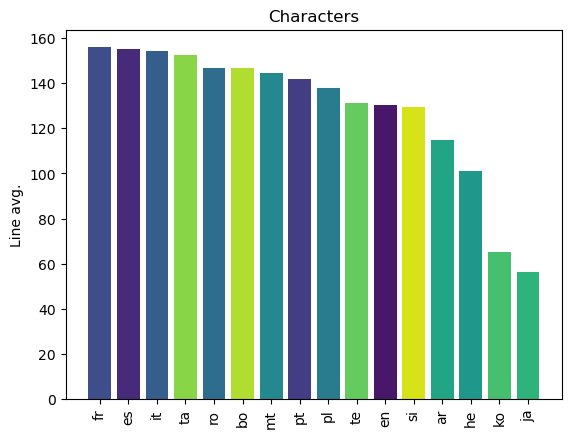

In [8]:
plot_token_numbers(flores_chars, "Characters")

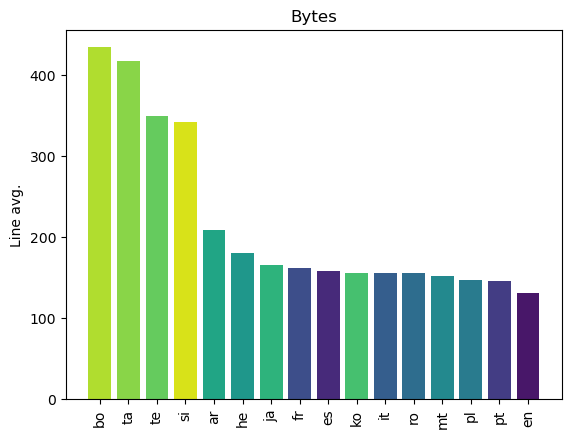

In [9]:
plot_token_numbers(flores_bytes, "Bytes")

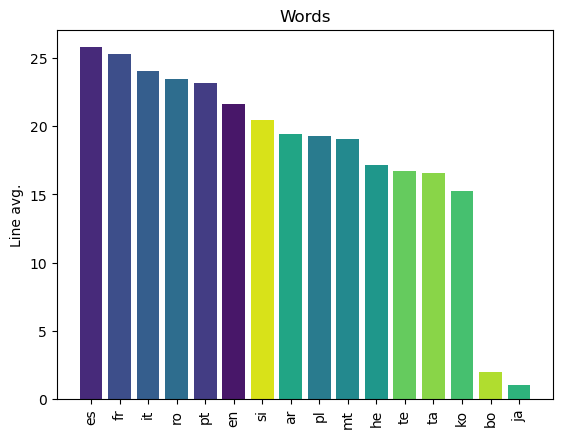

In [10]:
plot_token_numbers(flores_words, "Words")

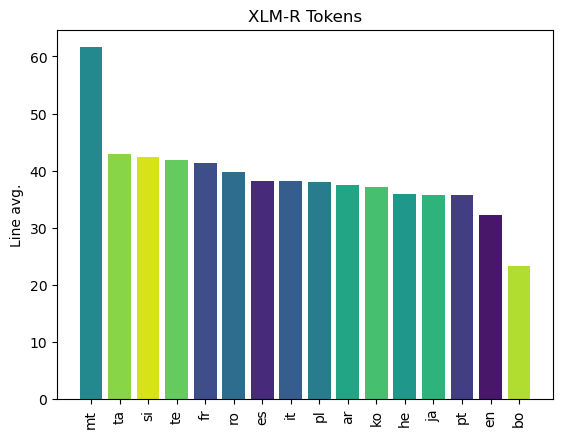

In [11]:
plot_token_numbers(flores_xlmr, "XLM-R Tokens")

Tibetan: majority token UNK

In [12]:
sum([sum(3 == np.array(lt))/len(lt) for lt in flores_xlmr['bo']]) / len(flores_xlmr['bo'])

0.4361741061165873

## Balenced BBPE on FLORES

In [ ]:
split="dev"
flores_tokenizers = build_gpt_tokenizer(f"flores200_dataset/{split}/joint.{split}", [10000, 50000,100000])
flores_il_tokenizers = {}
for lang in languages:
    flores_il_tokenizers[lang] = build_gpt_tokenizer(f"flores200_dataset/{split}/{languages_flores[lang]}.{split}", [2000, 10000,20000])


In [ ]:
flores_baltok = {lang: [flores_tokenizers['tokenizer_50000'].encode(line) for line in flores[lang]] for lang in flores.keys()}
flores_il_baltok = {lang: [flores_il_tokenizers[lang]['tokenizer_10000'].encode(line) for line in flores[lang]] for lang in flores.keys()}

In [ ]:
plot_token_numbers(flores_baltok, "Flores Balanced Tokens")

In [ ]:
plot_token_numbers(flores_il_baltok, "Flores I-L Balanced Tokens")

## BBPE on Byte Lexicons

In [ ]:
#TOODO

## Morfessor rewriting

In [ ]:
from src.rewrite_bytes import ByteRewriter
from src.utils import str_to_hex

In [ ]:
decompose_file = "../byte_maps/decompose.json"
morf_map_file = "../byte_maps/morf_map.json"
decompose_rewriter = ByteRewriter(decompose_file)
morf_rewriter = ByteRewriter(morf_map_file)

flores_decomposed_rw = {lang: [decompose_rewriter.rewrite_bytes(str_to_hex(line).split(' ')) for line in flores[lang]] for lang in flores.keys()}
flores_morfs_rw = {lang: [morf_rewriter.rewrite_bytes(decompose_rewriter.rewrite_bytes(str_to_hex(line).split(' '))) for line in flores[lang]] for lang in flores.keys()}

In [ ]:
title = f"Morfs rewritten in UTF-8 decompose"
plot_token_numbers(flores_decomposed_rw , title)

In [ ]:
title = f"Morfs rewritten in UTF-8"
plot_token_numbers(flores_morfs_rw , title)

## Morfessor experiments

In [13]:
def load_morfessor_results(split, byte_patches, morf_len, morf_type_num, joint=False):
    flores_morfs = {}
    file_name= f"{split}_bp_{byte_patches}_ml_{morf_len}_mtn_{morf_type_num}"
    if joint:
        file_name = "joint_" + file_name
    for lang in languages:
        lang_fl = languages_flores[lang]
        path = f'morfessor_out/{lang_fl}/{file_name}.seg.decoded'
        try:
            with open(path, 'r') as f:
                flores_morfs[lang] = f.read().splitlines()
        except FileNotFoundError:
            print(f"File {path} not found")
            flores_morfs[lang] = [""]
    flores_morfs = {lang: [line.split() for line in flores_morfs[lang]] for lang in flores_morfs.keys()}

    return flores_morfs

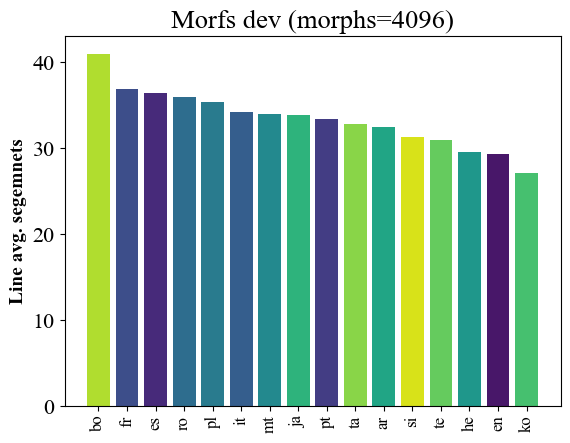

In [34]:
split = "dev"
byte_patches = 36
morf_len = 0
morf_type_num = 4096

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morfs {split} (morphs={morf_type_num})"
plot_token_numbers(flores_morfs, title)

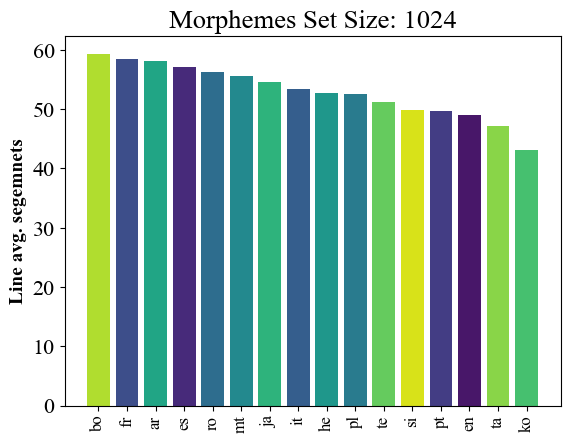

In [36]:
split = "dev"
byte_patches = 36
morf_len = 0
morf_type_num = 1024

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morphemes Set Size: {morf_type_num}"
plot_token_numbers(flores_morfs, title)

File morfessor_out/eng_Latn/joint_dev_bp_24_ml_0_mtn_1024.seg.decoded not found
File morfessor_out/spa_Latn/joint_dev_bp_24_ml_0_mtn_1024.seg.decoded not found
File morfessor_out/por_Latn/joint_dev_bp_24_ml_0_mtn_1024.seg.decoded not found
File morfessor_out/fra_Latn/joint_dev_bp_24_ml_0_mtn_1024.seg.decoded not found
File morfessor_out/ita_Latn/joint_dev_bp_24_ml_0_mtn_1024.seg.decoded not found
File morfessor_out/ron_Latn/joint_dev_bp_24_ml_0_mtn_1024.seg.decoded not found
File morfessor_out/pol_Latn/joint_dev_bp_24_ml_0_mtn_1024.seg.decoded not found
File morfessor_out/mlt_Latn/joint_dev_bp_24_ml_0_mtn_1024.seg.decoded not found
File morfessor_out/heb_Hebr/joint_dev_bp_24_ml_0_mtn_1024.seg.decoded not found
File morfessor_out/arb_Arab/joint_dev_bp_24_ml_0_mtn_1024.seg.decoded not found
File morfessor_out/jpn_Jpan/joint_dev_bp_24_ml_0_mtn_1024.seg.decoded not found
File morfessor_out/kor_Hang/joint_dev_bp_24_ml_0_mtn_1024.seg.decoded not found
File morfessor_out/tel_Telu/joint_dev_bp

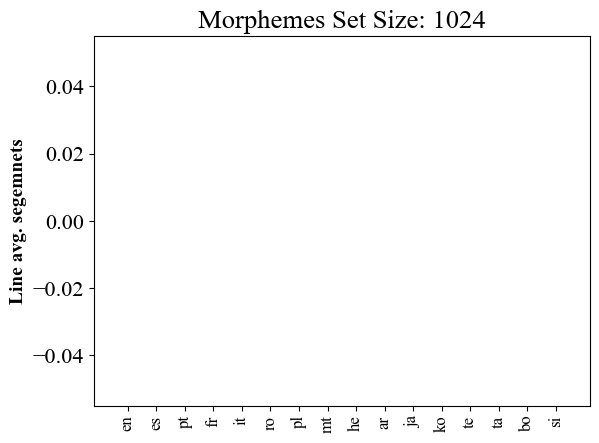

In [29]:
split = "joint_dev"
byte_patches = 24
morf_len = 0
morf_type_num = 1024

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morphemes Set Size: {morf_type_num}"
plot_token_numbers(flores_morfs, title)

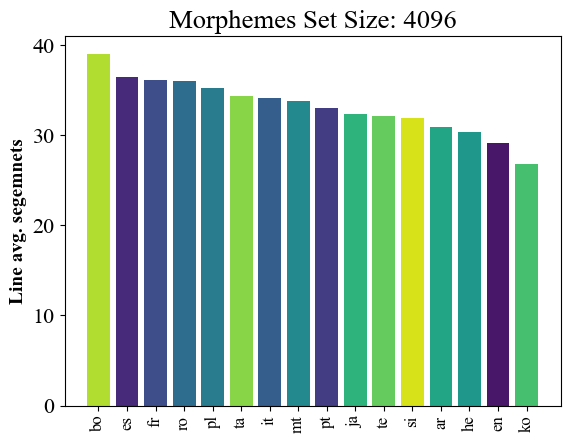

In [24]:
split = "dev"
byte_patches = 24
morf_len = 0
morf_type_num = 4096

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morphemes Set Size: {morf_type_num}"
plot_token_numbers(flores_morfs, title)

File morfessor_out/eng_Latn/dev_bp_24_ml_0_mtn_16384.seg.decoded not found
File morfessor_out/spa_Latn/dev_bp_24_ml_0_mtn_16384.seg.decoded not found
File morfessor_out/por_Latn/dev_bp_24_ml_0_mtn_16384.seg.decoded not found
File morfessor_out/fra_Latn/dev_bp_24_ml_0_mtn_16384.seg.decoded not found
File morfessor_out/ita_Latn/dev_bp_24_ml_0_mtn_16384.seg.decoded not found
File morfessor_out/ron_Latn/dev_bp_24_ml_0_mtn_16384.seg.decoded not found
File morfessor_out/pol_Latn/dev_bp_24_ml_0_mtn_16384.seg.decoded not found
File morfessor_out/mlt_Latn/dev_bp_24_ml_0_mtn_16384.seg.decoded not found
File morfessor_out/heb_Hebr/dev_bp_24_ml_0_mtn_16384.seg.decoded not found
File morfessor_out/arb_Arab/dev_bp_24_ml_0_mtn_16384.seg.decoded not found
File morfessor_out/jpn_Jpan/dev_bp_24_ml_0_mtn_16384.seg.decoded not found
File morfessor_out/kor_Hang/dev_bp_24_ml_0_mtn_16384.seg.decoded not found
File morfessor_out/tel_Telu/dev_bp_24_ml_0_mtn_16384.seg.decoded not found
File morfessor_out/tam_Ta

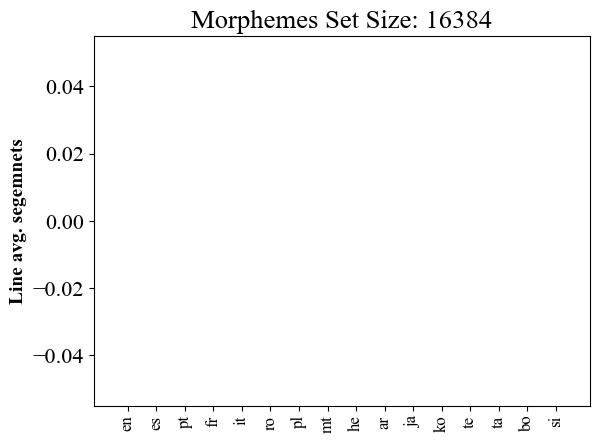

In [26]:
split = "dev"
byte_patches = 24
morf_len = 0
morf_type_num = 16384

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morphemes Set Size: {morf_type_num}"
plot_token_numbers(flores_morfs, title)

In [ ]:
split = "dev"
byte_patches = 24
morf_len = 0
morf_type_num = 819

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morphemes Set Size: {morf_type_num})"
plot_token_numbers(flores_morfs, title)

In [15]:
split = "devtest"
byte_patches = 24
morf_len = 0
morf_type_num = 4096

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morfs {split} (bp={byte_patches}, ml={morf_len}, mtn={morf_type_num})"
plot_token_numbers(flores_morfs, title)

ZeroDivisionError: division by zero

## Joint analysis

In [ ]:
split = "dev"
byte_patches = 24
morf_len = 0
morf_type_num = 16384

flores_morfs_joint = load_morfessor_results(split, byte_patches, morf_len, morf_type_num, joint=True)
title = f"Morfs joint {split} (bp={byte_patches}, ml={morf_len}, mtn={morf_type_num})"
plot_token_numbers(flores_morfs_joint, title)

In [ ]:
split = "devtest"
byte_patches = 24
morf_len = 0
morf_type_num = 16384

flores_morfs_joint = load_morfessor_results(split, byte_patches, morf_len, morf_type_num, joint=True)
title = f"Morfs joint {split} (bp={byte_patches}, ml={morf_len}, mtn={morf_type_num})"
plot_token_numbers(flores_morfs_joint, title)

## Comparision of methods 

In [ ]:
plot_compare_token_numbers([flores_bytes, flores_morfs, flores_morfs_joint, flores_chars, flores_xlmr, flores_baltok,flores_il_baltok, flores_words] ,
                           ['bytes','morfs','morfs (joint)', 'chars', 'xlmr T', 'Balanced BBPE J','Balanced BBPE I-L', 'words'])

In [ ]:
plot_compare_token_numbers([flores_bytes, flores_morfs, flores_morfs_joint, flores_chars, flores_xlmr, flores_baltok, flores_il_baltok, flores_words] ,
                           ['bytes','morfs','morfs (joint)', 'chars', 'xlmr T', 'Balanced BBPE J','Balanced BBPE I-L', 'words'], parity='en')